# Using RDEA to identify marker genes for mortality in pediatric sepsis 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

from rdea.eval.cross_validation import do_cross_validation, do_cross_validation_with_feature_selection
from rdea.filters.embedded import EmbeddedFilter
from rdea.filters.mrmr import MRMRP
from rdea.utils.help_functions import model_based_relevance, auc_relevance, load_DEGs


import matplotlib.pyplot as plt
%matplotlib inline   
import seaborn as sns
import warnings

# Comment these lines if you are not using Mac OS
import matplotlib as mpl
# mpl.use('MacOSX')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set random seed
seed = 7
np.random.seed(seed)

## Inputs and parameters

In [2]:
# ========== INPUTS ==========

# in and out files
data_file = './data/GSE66099.csv'
degs_file = './data/GSE66099_DEGs.txt'   # If None, all genes will be considered.
out_file = './results/sepsis/fs_scores.csv'
is_save_results = True

# data pre-processing
is_normalize_samples = False
is_normalize_columns = True
norm_filter = MinMaxScaler()

# experiment
num_folds = 10
num_runs = 10
label = 'Died'

# feature selection
num_features = 10
fsm = MRMRP(relevance_func= auc_relevance, redundancy_func=stats.pearsonr, num_features=num_features)

# classifier
model = SGDClassifier(loss="log", penalty="l2", random_state=seed)

# ========== OTHER INPUTS ==========
top_markers_to_viz = 0     # set to zero to visualize all potential markers

<hr>
<b>Do not modify the code below this line.</b><br>
<hr>

In [3]:
# load DEGs if provided
if degs_file is not None:
    DEGs = load_DEGs(degs_file)
    print('{} DEGs loaded!'.format(len(DEGs)))
else:
    print('No DEGs provided. Pipeline will consider all genes.')

108 DEGs loaded!


In [4]:
# Load data and normalize (if needed)
df = pd.read_csv(data_file)
print('Shape of {0} is {1}'.format(data_file, df.shape))
y = df[label]
if degs_file is not None:
    df = df[DEGs]
else:
    df =df.drop([label],axis=1)
names = df.columns
X = df.values

# Normalize per sample?
if is_normalize_samples:
    X = norm_filter.fit_transform(X.T, y).T
    print('Samples Normalized..')
# Normalize per sample
elif is_normalize_columns:
    X = norm_filter.fit_transform(X, y)
    print('Genes Normalized..')
else:
    print('No normalization used..')
len(X[0])

Shape of ./data/GSE66099.csv is (199, 10603)
Genes Normalized..


108

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    res2, scores = do_cross_validation_with_feature_selection(X, y,model=model, num_folds=num_folds, 
                                                              fs_model=fsm, n_runs=num_runs)
    print('ACC\tSn\tSp\tMCC\tAUC')
    print(res2['metrics'])
    #print(scores)


    dict = {'feature': names, 'score': scores}
    df = pd.DataFrame(dict, columns=['feature', 'score'],index=None)
    

ACC	Sn	Sp	MCC	AUC
[0.85868421 0.48666667 0.92183007 0.43872353 0.84952614]


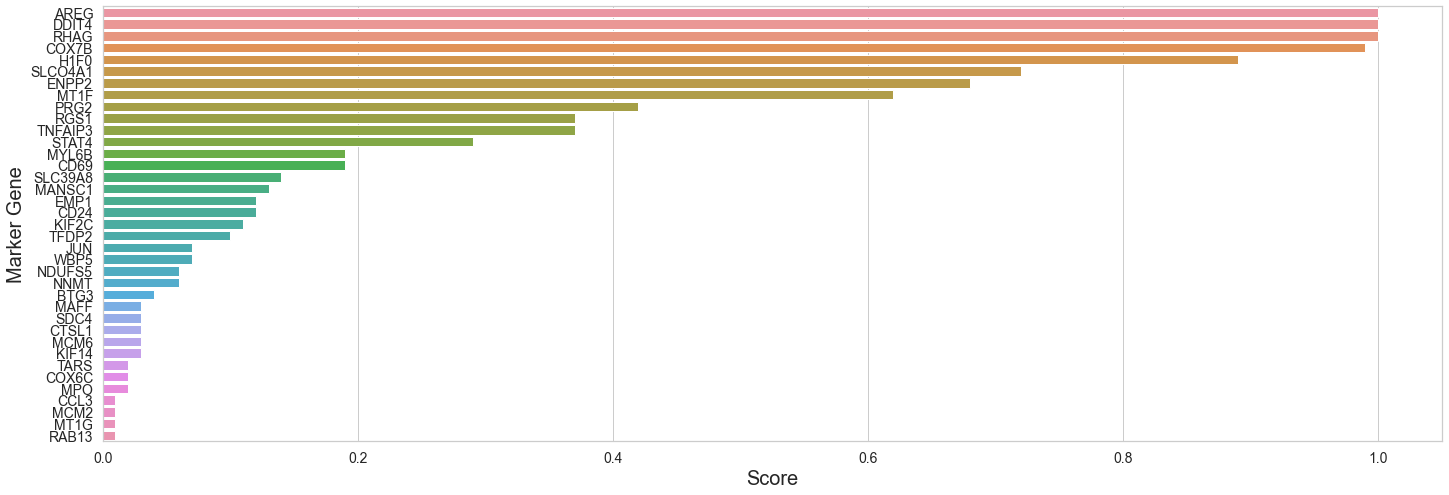

In [8]:
plt.figure(figsize=(24, 8))
sns.set(style="whitegrid")
# Rotate x-labels
#plt.xticks(rotation=-45)
df = df[df['score']!=0]
df = df.sort_values(by=['score'], ascending=False)
if top_markers_to_viz != 0:
    b = sns.barplot(data=df.head(top_markers_to_viz), x='score', y='feature',  orient='h') 
else:
    b = sns.barplot(data=df, x='score', y='feature',  orient='h') 

b.set_xlabel("Score",fontsize=20)
b.set_ylabel("Marker Gene",fontsize=20)
b.tick_params(labelsize=14)

In [13]:
data=df
data

,feature,score
45,AREG,1.00
2,DDIT4,1.00
1,RHAG,1.00
77,COX7B,0.99
43,H1F0,0.89
14,SLCO4A1,0.72
8,ENPP2,0.68
75,MT1F,0.62
12,PRG2,0.42
19,RGS1,0.37


In [14]:
# Save the list of sorted genes with non-zero importance scores
if is_save_results:
    df.to_csv(out_file, index=False)
    print('Output file, {}, saved..'.format(out_file))

Output file, ./results/sepsis/fs_scores.csv, saved..


In [17]:
if top_markers_to_viz != 0:
    df.head(top_markers_to_viz)
else:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        print(df)

In [9]:
print('Our analysis reduced the number of potential biomarkers from {0} to {1} genes and associated an importance score with each gene.'.format(len(DEGs), df.shape[0]))
print('Now, the user can use the importance scores to decide on the set of makers or can use the performance of a classifier'+\
     ' evaluated using top genes to decied on the optimal number of marker genes (See xxxx for more details).')

Our analysis reduced the number of potential biomarkers from 108 to 37 genes and associated an importance score with each gene.
Now, the user can use the importance scores to decide on the set of makers or can use the performance of a classifier evaluated using top genes to decied on the optimal number of marker genes (See xxxx for more details).
